In [ ]:
# Install required libraries
!pip install tweepy textblob networkx matplotlib --quiet


Overall Sentiment Analysis:
  Sentiment Score: 0.07
  Sentiment Type: Positive


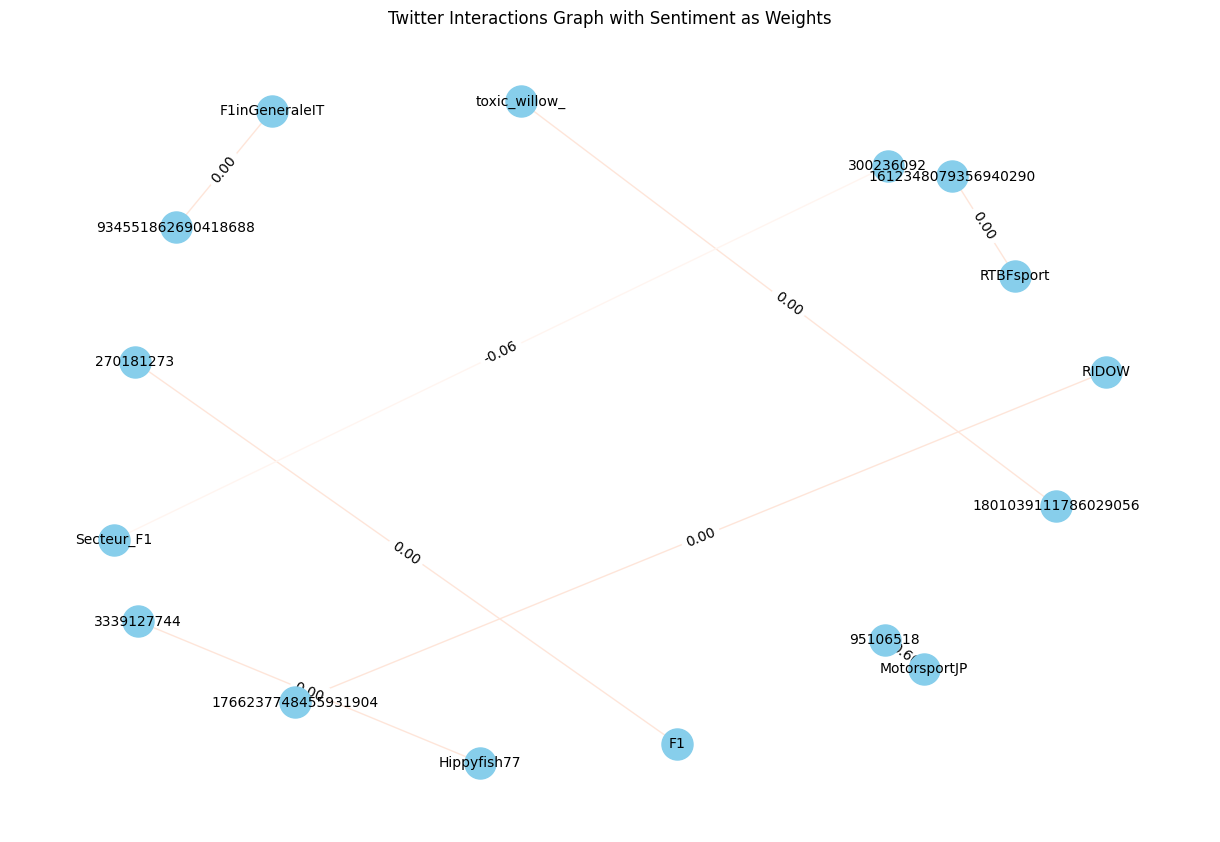

In [10]:
import tweepy
from textblob import TextBlob
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# API credentials
API_KEY = "LHV9AR2psEpZbxSEfJUl1AJDd"
API_SECRET = "5clqRvgalz4x2e5KV1EB74JRrFWZRDOaZsDm4OB6wngWKpK1p7"
ACCESS_TOKEN = "1857802552114651136-D7YRLsU2lTdwgyRFhAbOemj3Trv0gd"
ACCESS_TOKEN_SECRET = "b2xvdnsRCSkMgwzGY1ezjkgtZz2mp8dIij2oisSXJ1xtx"
BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAALgLxAEAAAAAyd2jit6huIg7aPGZoQKunJMwCkE%3DFjobnmlVHNCwNNgZQBKwzT00lGnlXBBg1mip4NarcKtaaxUKoJ"

# Authenticating Twitter API
auth = tweepy.OAuthHandler(API_KEY, API_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth)
client = tweepy.Client(bearer_token=BEARER_TOKEN)

# Verify credentials
# try:
#     user = api.verify_credentials()
#     if user:
#         print(f"Logged in as: {user.name}")
#     else:
#         print("Unable to verify credentials.")
# except tweepy.TweepyException as e:
#     print(f"Error: {e}")


def fetch_tweets(query, max_results=10):
    interactions = []
    tweet_texts = []
    try:
        tweets = client.search_recent_tweets(query=query, max_results=max_results, tweet_fields=["author_id", "entities", "text"])
        if tweets.data:
            for tweet in tweets.data:
                author = tweet.author_id
                tweet_texts.append(tweet.text)
                if tweet.entities and "mentions" in tweet.entities:
                    for mention in tweet.entities["mentions"]:
                        interactions.append((author, mention["username"]))  # Create edges: author -> mentioned user
    except Exception as e:
        print(f"Error fetching tweets: {e}")
    return interactions, tweet_texts

query = "f1 OR formula1 -is:retweet lang:en"
interactions, tweet_texts = fetch_tweets(query)


def analyze_sentiment(tweet_texts):
    sentiments = []
    for text in tweet_texts:
        polarity = TextBlob(text).sentiment.polarity
        sentiments.append(polarity)
    return sentiments

sentiments = analyze_sentiment(tweet_texts)


def build_graph(interactions, sentiments):
    G = nx.Graph()
    for i, (source, target) in enumerate(interactions):
        sentiment = sentiments[i % len(sentiments)] if sentiments else 0.0
        G.add_edge(source, target, weight=sentiment)
    return G

G = build_graph(interactions, sentiments)

def visualize_graph(G):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    if G.edges:
        edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
        nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10, edge_color=weights, edge_cmap=plt.cm.Reds)
        nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)})
    else:
        nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10)
    plt.title("Twitter Interactions Graph with Sentiment as Weights")
    plt.show()


def calculate_overall_sentiment(G):
    def sentiment_category(score):
        if score > 0:
            return "Positive"
        elif score < 0:
            return "Negative"
        return "Neutral"

    all_sentiments = []
    for _, _, data in G.edges(data=True):
       if 'weight' in data:
          all_sentiments.append(data['weight'])

    overall_sentiment = sum(all_sentiments) / len(all_sentiments) if all_sentiments else 0
    sentiment_type = sentiment_category(overall_sentiment)

    print("\nOverall Sentiment Analysis:")
    print(f"  Sentiment Score: {overall_sentiment:.2f}")
    print(f"  Sentiment Type: {sentiment_type}")

calculate_overall_sentiment(G)

visualize_graph(G)
